In [ ]:
%%capture
!pip install dynamiqs

In [ ]:
import dynamiqs as dq
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

## 1. Simulate the dynamics of cat qubits at the effective Hamiltonian level.

In Tutorial 1, we have introduced that we can dissipatively stabilize a cat qubit by coupling a memory mode  that will store our cat qubit to a lossy buffer mode with a specific interaction that exchanges two photons of the memory mode with one photon in the buffer mode.

For this, consider the Lindblad master equation:

$$\frac{d \hat{\rho}}{dt} = \mathcal{L}[\hat{\rho}] = -i \left[\hat{H}, \hat{\rho}\right] + \kappa_b \mathcal{D}(\hat{b})[\hat{\rho}]$$

The Hamiltonian of the system is given by

\begin{aligned}
\hat{H} &= \hat{H}_{\mathrm{2ph}} + \hat{H}_d,\qquad \mathrm{with}\\
\hat{H}_{\mathrm{2ph}} &= g_2 {{}\hat{a}^\dagger}^2 \hat{b} + g_2^* \hat{a}^2 \hat{b}^\dagger,\\
\hat{H}_d &= \epsilon_d^* \hat{b} + \epsilon_d \hat{b}^\dagger.
\end{aligned}

Here, $\hat{H}_{\mathrm{2ph}}$ is the two-photon exchange Hamiltonian and $\hat{H}_d$ is the buffer drive Hamiltonian.

**Task 1.1: Getting started with `dynamiqs`**

Using `dynamiqs`, simulate the time-evolution of this system with the following parameters:


\begin{aligned}
g_2 = 1.0\\
\epsilon_d = -4\\
\kappa_b = 10
\end{aligned}

(For now, we pretend that the parameters are without dimensions)

Use an initial state $\lvert \psi_0 \rangle$ in which both the buffer and the memory are in the vacuum. Use a Hilbert-space truncation of $n_a = 20$ and $n_b = 5$ (number of Fock-states in mode a and mode b, respectively) to begin with. You can play with a different Hilbert-space truncation.

Simulate the dynamics for a time $T=4$.

Plot the wigner function of mode a (as a GIF or as a mosaic plot).

Also plot the expectation value of the number of photons, as well as the photon number parity in the memory mode.

In [ ]:
g2 = 1.0
ed = -3
kb = 10
na = 20
nb = 5
T = 4

a = dq.destroy(na)
b = dq.destroy(nb)

a_ext = dq.tensor(a, dq.eye(nb))
a_ext2 = dq.tensor(a.powm(2), dq.eye(nb))
b_ext = dq.tensor(dq.eye(na), b)

a_ext_dag = dq.tensor(a.dag(), dq.eye(nb))
a_ext_dag2 = dq.tensor(a.dag().powm(2), dq.eye(nb))
b_ext_dag = dq.tensor(dq.eye(na), b.dag())

H2p = g2 * (a_ext_dag2 @ b_ext) + jnp.conj(g2) * (a_ext2 @ b_ext_dag)
Hd = jnp.conj(ed) * b_ext + ed * b_ext_dag
H = H2p + Hd

Here, we implemented the Hamiltonian as defined by the question. Here, we used `dq.tensor` with the identity matrix to make the dimensions of $\hat a$ and $\hat b$ match

In [ ]:
tsave = jnp.linspace(0, T, 50)

rho = dq.tensor(dq.fock_dm(na, 0), dq.fock_dm(nb, 0))

tsave = jnp.linspace(0, T, 50)
loss_op = [jnp.sqrt(kb) * b_ext]

res1 = dq.mesolve(H, loss_op, rho, tsave)

|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?

|██████████| 100.0% ◆ elapsed 1.43s ◆ remaining 0.00ms 


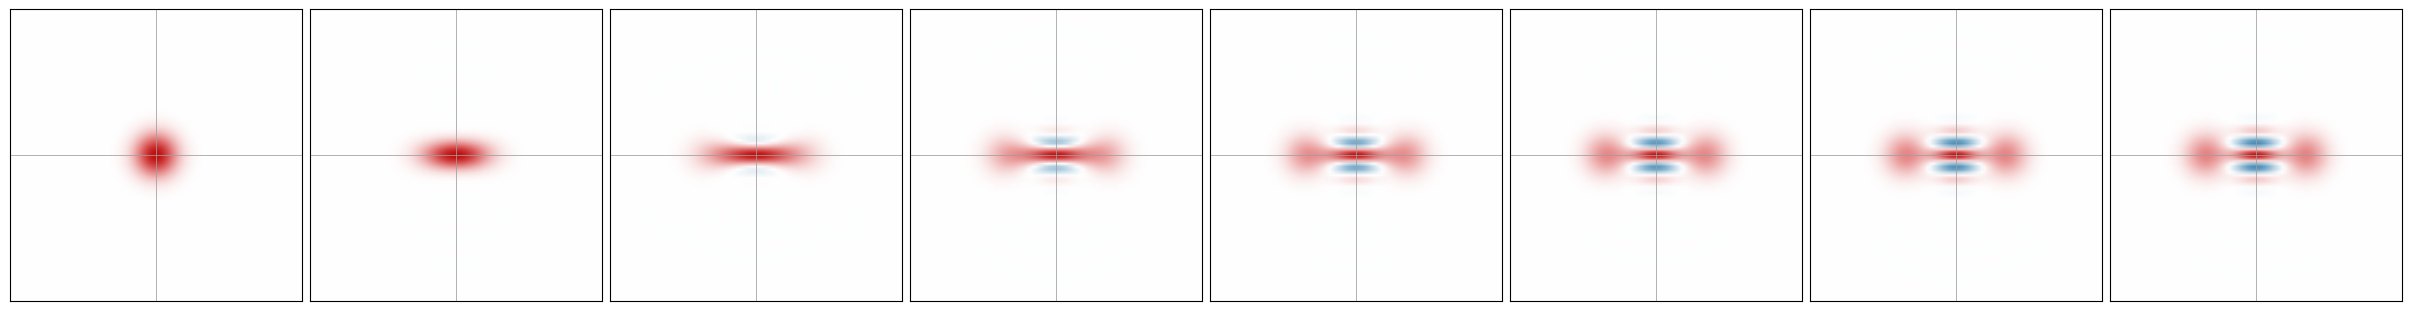

In [ ]:
res_a = dq.ptrace(res1.states, 0, (na, nb))
dq.plot.wigner_mosaic(res_a, cross = True)

Here we did a partial trace to separate the activities of mode a from the combined activites of mode a and mode b.

/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


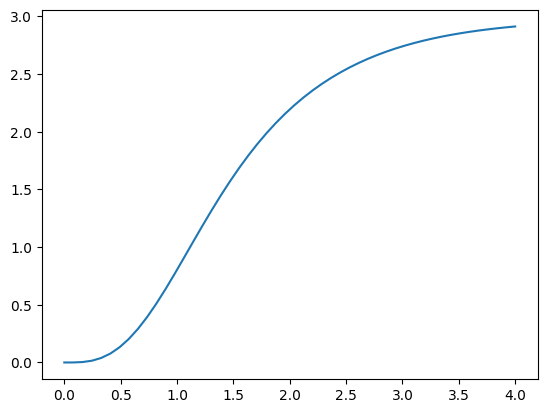

In [ ]:
n_exp = dq.expect(a.dag() @ a, res_a)
plt.plot(tsave, n_exp)

In the above, we applied the photon number operator:
$$
\hat n = \hat a^†\hat a
$$
on the resultant states, to obtain the expectation value of the number of photons throughout the process.

It makes sense that the number increases, as the systems reaches higher energy, it gains more photons.

/usr/local/lib/python3.11/dist-packages/equinox/_module.py:1096: UserWarning: A `SparseDIAQArray` has been converted to a `DenseQArray` while computing its matrix exponential.
  return self.__func__(self.__self__, *args, **kwargs)


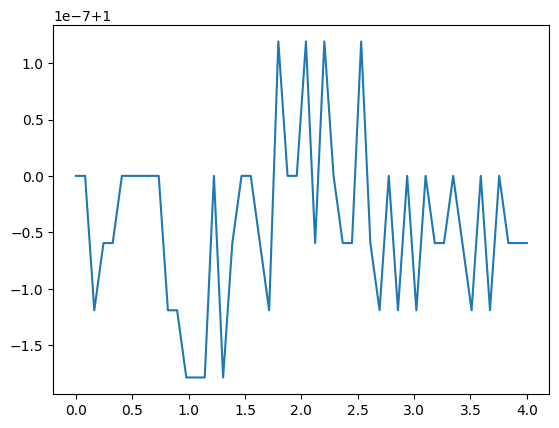

In [ ]:
parity_exp = dq.expect(dq.expm(1j * jnp.pi * (a.dag() @ a)), res_a)
plt.plot(tsave, parity_exp)

Here we used the photon number parity operator:
$$
\hat P = e^{i\pi\hat n}
$$
where $\hat n$ is the photon number operator, as defined above.

**Task 1.2: Comparison with eliminated buffer mode**

Compare your result from Task 1.1 to the system where the buffer mode is adiabatically eliminated, in which the dynamics of the memory mode is given by:

$$
\frac{d \hat{\rho}_a}{d t} = \kappa_2 \mathcal{D}[\hat{a}^2 - \alpha^2](\hat{\rho}_a),
$$

with two-photon dissipation rate $\kappa_2 = 4|g_2|^2 / \kappa_b$ and cat amplitude $\alpha^2 = -\epsilon_d/g_2^*$.

Compute the time-evolution of the fidelity between the time-evolved states computed with the two-mode system from Task 1.1. What do you observe if you lower $\kappa_b$?

In [ ]:
k2 = 4 * jnp.abs(g2)**2/kb
alpha2 = -ed/jnp.conj(g2)

rhoa = dq.fock(na, 0)
Ha = dq.zeros(na)
lop = jnp.sqrt(k2) * (a @ a - alpha2 * dq.eye(na))
res2 = dq.mesolve(Ha, [lop], rhoa, tsave)

|          |   0.2% ◆ elapsed 2.62ms ◆ remaining 0.00ms

Here we applied the given Hamiltonian and obtained something that looked a lot like our results from 1.1.

This makes sense as 1.1 is the adiabatic limit of 1.2

|██████████| 100.0% ◆ elapsed 296.93ms ◆ remaining 0.00ms 


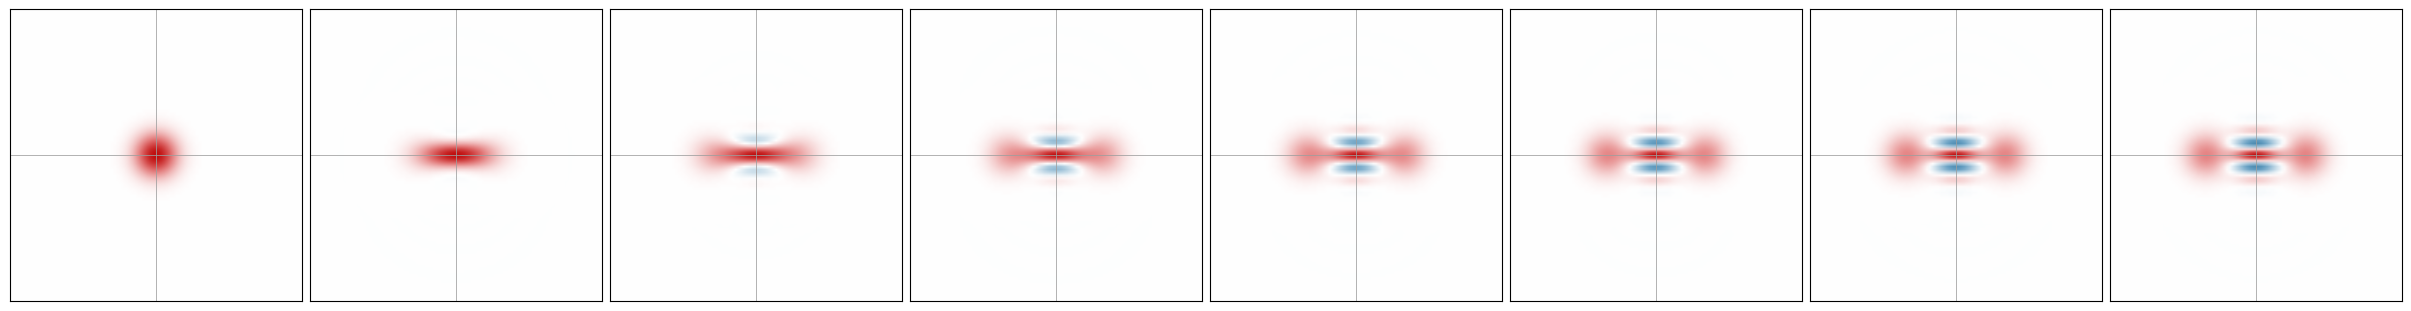

In [ ]:
dq.plot.wigner_mosaic(res2.states, cross = True)

**Task 1.3: Performing a Zeno-gate**

To fully control a cat qubit, we also need to be able to perform gates.

**$Z(\theta)$-rotation**: In addition to the dissipative stabilization mechanism simulated in Task 1.1, find a Hamiltonian that performs a contiuous rotation around the $Z$-axis of the qubit, also called Zeno gate, (as a reminder: the cat states $\lvert \mathcal{C}_\alpha^ \pm \rangle$ define the logical $X$-eigenstates $\lvert\pm\rangle$). This additional Hamiltonian has the form: $\hat{H}_Z = \epsilon_Z^* \hat{O} + \epsilon_Z \hat{O}^\dagger$, where $\hat{O}$ is a bosonic operator.

**a)** Simulate the time-evolution that maps $\lvert+\rangle$ to $\lvert-\rangle$ in a time $T_Z$, where $2T_Z$ is the time it takes to make a full rotation.
The speed of rotation will depend on the strenght of the parameter $\epsilon_Z$ in the Hamiltonian $H_Z$ that generates the rotation.

In [ ]:
tsave2 = jnp.linspace(0, T, 101)
ez = 1
Hz = jnp.conj(ez) * (jnp.exp(1j * 2 * jnp.pi/T) * a) + ez * (jnp.exp(1j * 2 * jnp.pi/T) * a).dag()
# Hz = jnp.conj(ez) * a_ext + ez * a_ext_dag

alpha = 2

plus = dq.unit(dq.coherent(na, alpha) + dq.coherent(na, -alpha))
minus = dq.unit(dq.coherent(na, alpha) - dq.coherent(na, -alpha))

res3 = dq.mesolve(Hz, [], plus, tsave2)

/usr/local/lib/python3.11/dist-packages/dynamiqs/integrators/apis/mesolve.py:138: UserWarning: Argument `jump_ops` is an empty list and argument `rho0` is a ket, consider using `dq.sesolve()` to solve the Schrödinger equation.
  _check_mesolve_args(H, Ls, rho0, exp_ops)
|████████▌ |  85.3% ◆ elapsed 9.94ms ◆ remaining 0.00ms

|██████████| 100.0% ◆ elapsed 54.62ms ◆ remaining 0.00ms


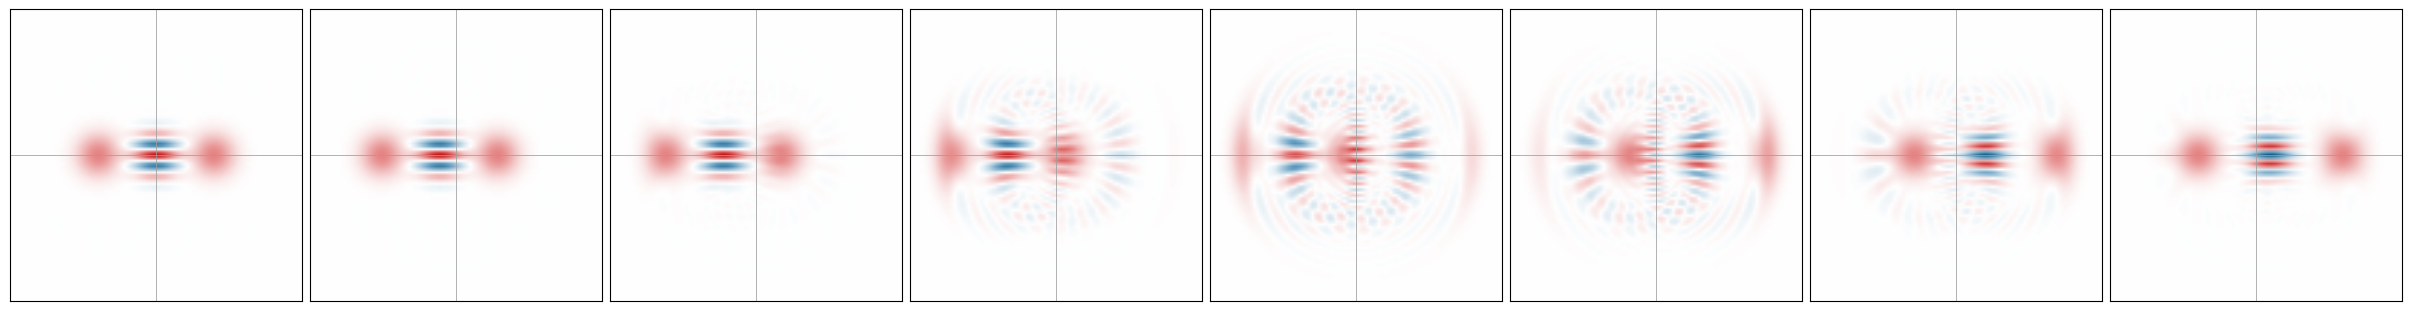

In [ ]:
dq.plot.wigner_mosaic(res3.states, cross=True)

Here, we think that $\hat O = e^{i\omega}\hat a$ where $\hat a$ is the annihilation operator and $\omega = \frac{2\pi}{T}$

**b)** Optimize parameters: In a real-world scenario, also our memory mode is subject to losses of single photons. Let $\kappa_a$ be the single-photon loss rate of mode a.

For various values of $\kappa_a$ from the interval $\kappa_a \in [0.01, 2]$ and for various values of $\epsilon_Z$, plot the parity as a function of time in the presence of $\hat{H}_Z$.

For the parameter range of $\kappa_a$ above, find the optimal times $T_Z$ for a rotation of $\theta = 0 \rightarrow \pi.$

In [ ]:
kappa_a = 1
lop = jnp.sqrt(kappa_a) * a

res4 = dq.mesolve(Hz, [lop], plus, tsave2)

|██████████| 100.0% ◆ elapsed 54.92ms ◆ remaining 0.00ms

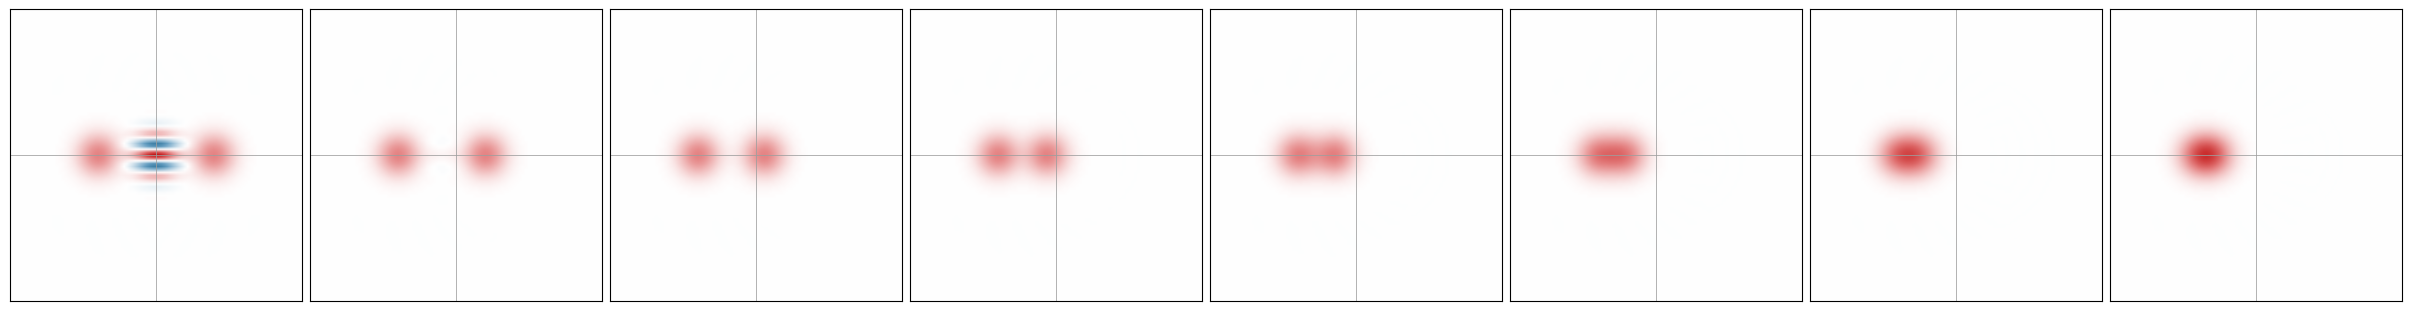

In [ ]:
dq.plot.wigner_mosaic(res4.states, cross=True)

|██████████| 100.0% ◆ elapsed 22.97ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 22.60ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 20.25ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 26.04ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 23.84ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 34.46ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 25.13ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 31.49ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 27.46ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 44.63ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 32.10ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 16.93ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 21.31ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 21.62ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 18.38ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 26.89ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 20.98ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 3

Text(0, 0.5, '')

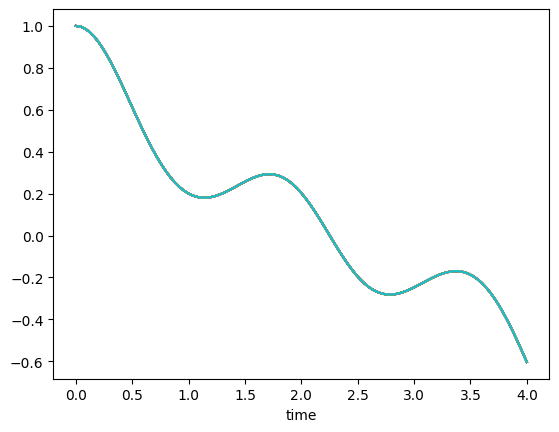

In [ ]:
for kappa_a in jnp.linspace(0.01, 2, 5):
  for ez in range(1,5):
      Hzz = jnp.conj(ez) * (jnp.exp(1j * 2 * jnp.pi/T) * a) + ez * (jnp.exp(1j * 2 * jnp.pi/T) * a).dag()
      res3b = dq.mesolve(Hz, [], plus, tsave2)
      parity_exp_z = dq.expect(dq.expm(1j * jnp.pi * (a.dag() @ a)), res3b.states)
      plt.plot(tsave2, parity_exp_z)
plt.xlabel("time")
plt.ylabel("")

We found the parity as a function of time in the presence of $\hat H_z$ to be the above. It appears that they are all the same across the ranges.

$T_z = 1$ is the optimal time.

**Task 1.4: Optimal control for state-preparation**

In Task 1.1, we assumed that the parameter $\epsilon_d$ in $\hat{H}_d$ is constant throughout the time evolution. Now, you will simulate what happens if we let $\epsilon_d$ depend on time.

We would like to answer the question: What is the optimal function of time of $\epsilon_d(t)$ to inflate a cat from the vacuum to a target value of $\alpha^2 = 4$ in a given time $T =3$?

For this, first find and define an adequate loss function.
Then, optimize over $\epsilon_d(t)$. For this, you can assume that $\hat{H}_d$ is piecewise constant. You can play with the number of bins in $\hat{H}_d$.
Plot the optimized value of $\epsilon_d(t)$ as a function of time.
What happens if you increase or decrease $T$?

In [ ]:
Tg = 3

tsave3 = jnp.linspace(0, Tg, 101)

edt = lambda t: jnp.exp(t)
Hdt = lambda t: dq.asqarray(jnp.conj(edt(t)) * b_ext + edt(t) * b_ext_dag)

H4 = H2p + dq.timecallable(Hdt)

rho4 = dq.tensor(dq.fock_dm(na, 0), dq.fock_dm(nb, 0))

res4 = dq.mesolve(H4, [loss_op], rho4, tsave3)

|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?

In [ ]:
dq.plot.wigner_mosaic(res4.states, cross = True)

|          |   0.3% ◆ elapsed 36.07ms ◆ remaining 0.00ms

ValueError: Argument `states` must have shape (N, n, 1) or (N, n, n), but has shape states.shape=(1, 101, 100, 100).